In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/b2/scratch/ahringer/jj374/lab/relmapping


In [2]:
df_regl = regl_addons()
print(len(df_regl))

7076 non-promoters outside of outron/gene body (=no gene_id)


/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13195 of 42245 sites with CV values via promoter annotation
32525 of 42245 sites with CV values via "associated gene"
42245


In [3]:
fp_ = 'annot/S3_genomic_regions/S3_genomic_regions.tsv'
df_regions = pd.read_csv(fp_, sep='\t')

In [4]:
df_regl = regl_addons()
df_mode = pd.DataFrame()
df_mode['chrom'] = df_regl['chrom'].copy()
df_mode['start'] = df_regl['atac_mode']
df_mode['end'] = df_regl['atac_mode'] + 1
df_regl_region = BedTool.from_dataframe(df_mode).map(
    b=BedTool.from_dataframe(df_regions).fn,
    c='4,5,6', o='distinct,distinct,distinct',
).to_dataframe()
df_regl_region.columns = df_regions.columns

7076 non-promoters outside of outron/gene body (=no gene_id)


/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13195 of 42245 sites with CV values via promoter annotation
32525 of 42245 sites with CV values via "associated gene"


In [5]:
df_regl['region_type'] = df_regl_region['type']
df_regl['region_strand'] = df_regl_region['strand']
df_regl['region_gene_id'] = df_regl_region['gene_id']

In [6]:
q_ = '(annot_fwd == "unknown_promoter" & annot_rev != "unknown_promoter")' \
   + '| (annot_fwd != "unknown_promoter" & annot_rev == "unknown_promoter")'
df_regl_u = df_regl.query(q_).reset_index(drop=True)

In [7]:
def type_(annot_fwd, annot_rev, region_type, region_strand):
    if annot_fwd == "unknown_promoter" and annot_rev != "unknown_promoter":
        if annot_rev == 'coding_promoter':
            return 'coding_promoter_antisense'
        elif region_type == 'intergenic':
            return 'intergenic'
        elif region_type in ['outronic', 'exonic', 'intronic', 'gene_end']:
            if region_strand == '-':
                return 'genic_region_antisense'
            else:
                return 'genic_region_sense'
        else:
            assert region_type == 'mixed'
            return 'mixed'

    elif annot_fwd != "unknown_promoter" and annot_rev == "unknown_promoter":
        if annot_fwd == 'coding_promoter':
            return 'coding_promoter_antisense'
        elif region_type == 'intergenic':
            return 'intergenic'
        elif region_type in ['outronic', 'exonic', 'intronic', 'gene_end']:
            if region_strand == '+':
                return 'genic_region_antisense'
            else:
                return 'genic_region_sense'
        else:
            assert region_type == 'mixed'
            return 'mixed'
    else: 
        return '.'

df_regl['unknown_promoter_type'] = list(map(type_, df_regl['annot_fwd'], df_regl['annot_rev'], df_regl['region_type'], df_regl['region_strand']))
df_regl['unknown_promoter_type'].value_counts().sort_index()

.                            37327
coding_promoter_antisense     1335
genic_region_antisense        2133
genic_region_sense             216
intergenic                    1055
mixed                          179
Name: unknown_promoter_type, dtype: int64

In [8]:
for type_ in df_regl['unknown_promoter_type'].value_counts().sort_index().index.tolist():
    if type_ == '.': continue
    fp_ = 'annot/Fig2S2a_unknown_promoter/unknown_promoter_%(type_)s.bed' % locals()
    df_regl.query('unknown_promoter_type == "%(type_)s"' % locals())[yp.NAMES_BED3].to_csv(fp_, sep='\t', index=False, header=False)
    !wc -l {fp_}

1335 annot/Fig2S2a_unknown_promoter/unknown_promoter_coding_promoter_antisense.bed
2133 annot/Fig2S2a_unknown_promoter/unknown_promoter_genic_region_antisense.bed
216 annot/Fig2S2a_unknown_promoter/unknown_promoter_genic_region_sense.bed
1055 annot/Fig2S2a_unknown_promoter/unknown_promoter_intergenic.bed
179 annot/Fig2S2a_unknown_promoter/unknown_promoter_mixed.bed


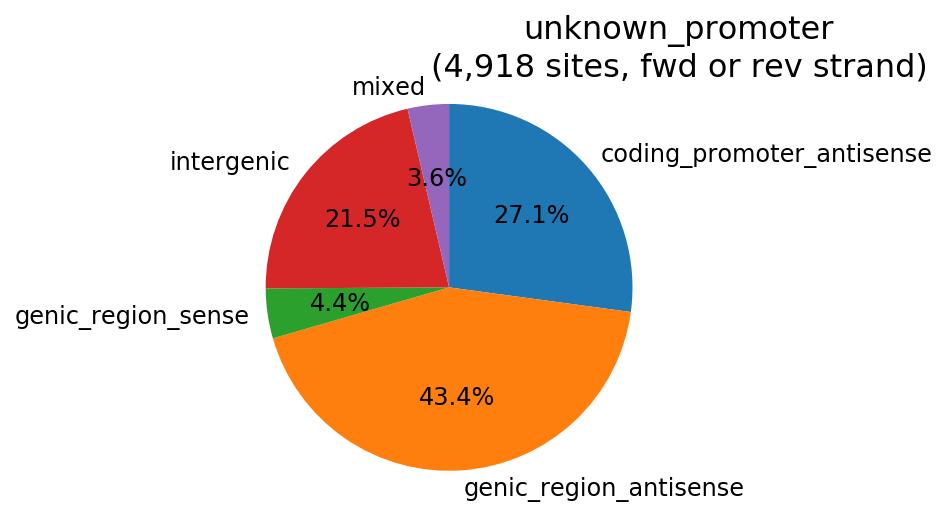

In [9]:
l_ = ['coding_promoter_antisense', 'genic_region_antisense', 'genic_region_sense', 'intergenic', 'mixed']
df_ = df_regl['unknown_promoter_type'].value_counts().sort_index()[l_]

fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
df_.plot( 
    #title='sites annotated as\n%s (%s)' % (label_, yp.f_uk(sum(df_mode_agg.values)),),
    label='',
    kind='pie',
    counterclock=False,
    autopct='%.1f%%',
    startangle=90,
    fontsize=12,
);
plt.axis('equal')

plt.suptitle('unknown_promoter\n(%s sites, fwd or rev strand)' % (yp.f_uk(df_.values.sum()),), fontsize=16)
plt.savefig('annot/Fig2S2a_unknown_promoter/Fig2S2l_unknown_promoter_pie.pdf', bbox_inches='tight', transparent=True)

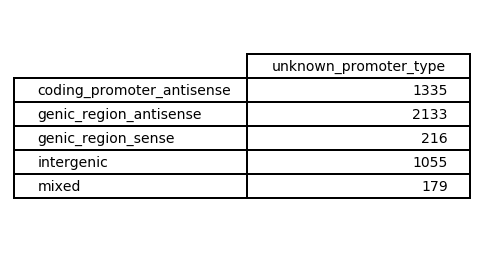

In [10]:
fig = plt.figure(figsize=(2,2))
plt.subplot(111, frame_on=False)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
pd.plotting.table(data=df_, ax=plt.gca(), loc='center left')
plt.savefig('annot/Fig2S2a_unknown_promoter/Fig2S2r_unknown_promoter_counts.pdf', bbox_inches='tight', transparent=True)